<a href="https://colab.research.google.com/github/zhukuixi/Fastai/blob/main/fastat_lesson3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 拟合三次函数的例子


In [19]:
from fastai.vision.all import *
from functools import partial
import numpy as np

from ipywidgets import interact
from fastai.basics import *



<module 'PIL.Image' from '/usr/local/lib/python3.7/dist-packages/PIL/Image.py'>

## 建立函数方程，用partial技巧完成参数可互动调节来改善拟合的可视化

In [4]:
def f(a,b,c,d,x):
  return a*x**3+b*x**2+c*x+d

def partial_f(a,b,c,d):
  return partial(f,a,b,c,d)

def mse(predValue,trueValue):
  return ((predValue-trueValue)**2).mean().sqrt()


In [5]:
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100).unsqueeze(1)
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

真实模型的参数设置，画出函数曲线图


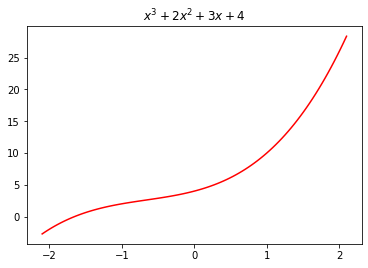

In [6]:
plot_function(partial_f(1,2,3,4),title="$x^3+2x^2+3x+4$")

x轴抽样20个点，加入噪音，完成syntheic data的绘制


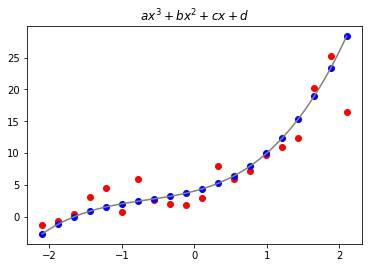

In [7]:
x = torch.linspace(-2.1,2.1,20).unsqueeze(1)
y = f(1,2,3,4,x)
np.random.seed(1897)
y_noise = y*(1+np.random.normal(scale=0.15,size=y.shape)) + np.random.normal(scale=1.5,size=y.shape)
plt.scatter(x,y_noise,color="red")
plt.scatter(x,y,color="blue")
plot_function(partial_f(1,2,3,4),title="$ax^3+bx^2+cx+d$",color="grey")

In [8]:
@interact(a=2.0, b=2.0, c=2.0,d=2.0)
def plot_quad(a, b, c,d):
    plt.scatter(x,y_noise,color="red")
    predValue = partial_f(a,b,c,d)(x)
    mseValue = mse(predValue,y_noise)
    plot_function(partial_f(a,b,c,d), ylim=(-15,30),title=f"${a}x^3+{b}x^2+{c}x+{d}$"+f" mse:{mseValue:0.3f}",color="grey")
    plt.plot(x,y,color="blue")

interactive(children=(FloatSlider(value=2.0, description='a', max=6.0, min=-2.0), FloatSlider(value=2.0, descr…

## 梯度下降的实现

In [9]:
def init_para(size,std=1.0):
  return (torch.randn(size)*std).requires_grad_()

In [10]:
lr = 0.1
torch.random.manual_seed(1897)
paras = init_para((4,1))
print(paras)
for i in range(20):
  predValue = partial_f(*paras)(x)  
  loss = mse(predValue,y_noise)
  loss.backward()
  paras.data -= paras.grad*lr
  paras.grad.zero_()
  print(f"epoch:{i} loss:{loss:.3f}")


tensor([[-0.2189],
        [-0.5554],
        [ 0.8496],
        [ 0.4029]], requires_grad=True)
epoch:0 loss:10.254
epoch:1 loss:9.398
epoch:2 loss:8.627
epoch:3 loss:7.938
epoch:4 loss:7.327
epoch:5 loss:6.784
epoch:6 loss:6.301
epoch:7 loss:5.868
epoch:8 loss:5.478
epoch:9 loss:5.126
epoch:10 loss:4.808
epoch:11 loss:4.524
epoch:12 loss:4.273
epoch:13 loss:4.054
epoch:14 loss:3.869
epoch:15 loss:3.713
epoch:16 loss:3.587
epoch:17 loss:3.485
epoch:18 loss:3.405
epoch:19 loss:3.341


# MNIST的例子
这里是个区分数字7和3的二分任务。  
* 一开始的想法是利用pixel similarity.也即找到所有标签为6(9)的图像，制造一张平均图。然后面对新的样本，比较这个样本和6与9的平均图的距离。  
* 然后我们用NN的SGD来实现。一开始是low level coding实现，然后是high level coding实现.

## MNIST的方案1：Pixel Similarity

In [11]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

In [12]:
threeTrainFiles = (path/'train/3').ls()
sevenTrainFiles = (path/'train/7').ls()
threeValidFiles = (path/'valid/3').ls()
sevenValidFiles = (path/'valid/7').ls()

In [20]:
im3 = Image.open(threeTrainFiles[0])
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,114,238,253,237,113,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,19,101,225,253,252,252,252,252,48,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,98,209,252,252,196,148,87,233,252,229,21,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,16,170,243,252,217,84,0,0,0,169,252,253,122,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,16,203,253,204,112,37,0,0,0,0,91,252,253,167,0,0,0,0,0,0,0
8,0,0,0,0,0,147,143,207,253,141,15,0,0,0,0,0,0,29,253,255,168,0,0,0,0,0,0,0
9,0,0,0,0,0,149,167,167,89,0,0,0,0,0,0,0,0,154,252,253,121,0,0,0,0,0,0,0


### 收集train set里头3和7的图片，并计算平均值图片

In [21]:
threeTrainTensor = torch.stack([tensor(Image.open(f)) for f in threeTrainFiles]).float()/255
sevenTrainTensor = torch.stack([tensor(Image.open(f)) for f in sevenTrainFiles]).float()/255

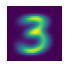

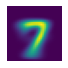

In [22]:
mean3 = threeTrainTensor.mean(0)
mean7 = sevenTrainTensor.mean(0)

show_image(mean3)
show_image(mean7)

In [23]:
threeValidTensor = torch.stack([tensor(Image.open(f)) for f in threeValidFiles]).float()/255
sevenValidTensor = torch.stack([tensor(Image.open(f)) for f in sevenValidFiles]).float()/255

In [24]:
validData_Y = tensor([0]*len(threeValidFiles)+[1]*len(sevenValidFiles))
validData_X = torch.cat([threeValidTensor,sevenValidTensor],axis=0)
validData = list(zip(validData_X,validData_Y))

In [27]:
def dist_mean3(sample):
  return F.mse_loss(sample,mean3)

def dist_mean7(sample):
  return F.mse_loss(sample,mean7)

In [29]:
predictResult  = tensor([0 if dist_mean3(sample[0])<dist_mean7(sample[0]) else 1 for sample in validData])


In [30]:
accuracy = (predictResult==validData_Y).float().mean()
print(f"The accuracy of pixel similarty based is {accuracy:.3f}")

The accuracy of pixel similarty based is 0.966


## MNIST的方案2：SGD

In [189]:

# loss function
def mnist_loss(predValue,trueValue):
  return torch.where(trueValue==1,1-predValue,predValue).mean()
# validation metric for one batch
def batch_accuracy(predValue,trueValue):
  return (torch.where(predValue>0.5,1,0)==trueValue).float().mean()


# Make DataLoader for training and valid dataset
trainData_X = torch.cat([threeTrainTensor,sevenTrainTensor],axis=0).view(-1,28*28)
trainData_Y = tensor([0]*len(threeTrainFiles)+[1]*len(sevenTrainFiles)).unsqueeze(1)

validData_X = torch.cat([threeValidTensor,sevenValidTensor],axis=0).view(-1,28*28)
validData_Y = tensor([0]*len(threeValidFiles)+[1]*len(sevenValidFiles)).unsqueeze(1)

trainData = list(zip(trainData_X,trainData_Y))
validData = list(zip(validData_X,validData_Y))
trainDataLoader = DataLoader(trainData,batch_size=256,shuffle=True)
validDataLoader = DataLoader(validData,batch_size=256,shuffle=True)




### low level 写法

In [ ]:

# model framework
def model(x):
  layer1_input = x@w1+bias1
  layer1_output = F.relu(layer1_input)
  layer2_input = layer1_output@w2+bias2
  layer2_output = torch.sigmoid(layer2_input)
  return layer2_output
  
# validation metric for one epoch
def validation_epoch(model):
  return torch.stack([batch_accuracy(model(x),y) for x,y in validDataLoader]).mean().item()

# Initialize parameters
torch.random.manual_seed(1897)
w1 = init_para((28*28,30))
bias1 = init_para(30)
w2 = init_para((30,1))
bias2 = init_para(1)

# learning 
def learning():
  lr = 1
  for epoch in range(20):
    for x,y in trainDataLoader:    
      # compute gradient
      pred = model(x)     
      loss = mnist_loss(pred,y)
      loss.backward()
      # update parameter
      w1.data -= w1.grad*lr
      bias1.data -= bias1.grad*lr      
      w1.grad.zero_()
      bias1.grad.zero_()  
    # check the performance on validation and loss on training for each epoch
    valiAcc = validation_epoch(model)      
    print(f"validation accuracy:{valiAcc:.4f}")
    print(f"epoch:{epoch},loss:{loss:.4f}\n")
   


In [190]:
learning()

validation accuracy:0.9019
epoch:0,loss:0.0769

validation accuracy:0.9407
epoch:1,loss:0.0468

validation accuracy:0.9515
epoch:2,loss:0.0649

validation accuracy:0.9607
epoch:3,loss:0.0467

validation accuracy:0.9646
epoch:4,loss:0.0272

validation accuracy:0.9671
epoch:5,loss:0.0128

validation accuracy:0.9681
epoch:6,loss:0.0492

validation accuracy:0.9701
epoch:7,loss:0.0278

validation accuracy:0.9701
epoch:8,loss:0.0268

validation accuracy:0.9706
epoch:9,loss:0.0384

validation accuracy:0.9740
epoch:10,loss:0.0218

validation accuracy:0.9724
epoch:11,loss:0.0303

validation accuracy:0.9740
epoch:12,loss:0.0372

validation accuracy:0.9750
epoch:13,loss:0.0341

validation accuracy:0.9750
epoch:14,loss:0.0356

validation accuracy:0.9773
epoch:15,loss:0.0278

validation accuracy:0.9764
epoch:16,loss:0.0558

validation accuracy:0.9765
epoch:17,loss:0.0292

validation accuracy:0.9775
epoch:18,loss:0.0114

validation accuracy:0.9775
epoch:19,loss:0.0194



### High Level写法 (fastai api)

In [210]:

dls = DataLoaders(trainDataLoader,validDataLoader)

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1),
    nn.Sigmoid()
)
# mnist_loss和batch_accuracy是之前自定义的函数
learn = Learner(dls,simple_net,opt_func=SGD,loss_func=mnist_loss,metrics=batch_accuracy)
learn.fit(40,0.1)


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.219213,0.089206,0.965653,00:00
1,0.104914,0.053397,0.968597,00:00
2,0.065493,0.044266,0.970069,00:00
3,0.048232,0.039384,0.970559,00:00
4,0.038625,0.036541,0.970069,00:00
5,0.034190,0.034525,0.973503,00:00
6,0.030785,0.033154,0.973994,00:00
7,0.028309,0.031593,0.975466,00:00
8,0.026753,0.030612,0.974485,00:00
9,0.025502,0.029765,0.974485,00:00


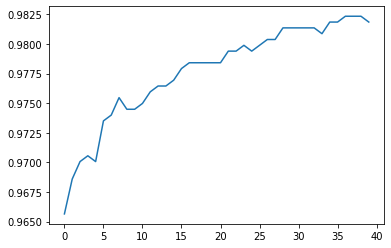

In [211]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [214]:
learn.recorder.values[-1][2]

0.981844961643219